In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tests.slice_acquisition.test_slice_acq import *
from sigpy import shepp_logan
import torch

def show_slices(volume, title="Slices"):
    """ Function to display row of image slices """
    if isinstance(volume, torch.Tensor):
        volume = volume.detach().cpu().numpy()
    h, w, l = volume.shape
    slice_0 = volume[h // 2, :, :]
    slice_1 = volume[:, w // 2, :]
    slice_2 = volume[:, :, l // 2]
    slices = [slice_0, slice_1, slice_2]
    
    fig, axes = plt.subplots(1, len(slices))
    fig.suptitle(title)
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
    return fig

## Test phantom reconstruction with different angles

Creating a Phantom of (240, 240, 240) with resolution 1


/data/wenxuan/NeSVoR/tests/slice_acquisition/test_slice_acq.py:126: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  volume = torch.tensor(volume, dtype=torch.float32).cuda().contiguous()


Testing angles: [[0, 0, 0], [1.5707963267948966, 0, 0], [0, 1.5707963267948966, 0], [0, 0, 1.5707963267948966], [0.7853981633974483, 0.7853981633974483, 0], [0, 0.7853981633974483, 0.7853981633974483], [0.7853981633974483, 0, 0.7853981633974483], [1.0471975511965976, 1.0471975511965976, 0], [0, 1.0471975511965976, 1.0471975511965976], [1.0471975511965976, 0, 1.0471975511965976], [2.0943951023931953, 2.0943951023931953, 0], [0, 2.0943951023931953, 2.0943951023931953], [2.0943951023931953, 0, 2.0943951023931953], [0.6283185307179586, 0.6283185307179586, 0], [0, 0.6283185307179586, 0.6283185307179586], [0.6283185307179586, 0, 0.6283185307179586]]
Mismatches: 2277916/13824000 (16.0%),                     
max error: 0.0021598339080810547
mean error: 1.9266097297077067e-05
----------------------------------------------------------


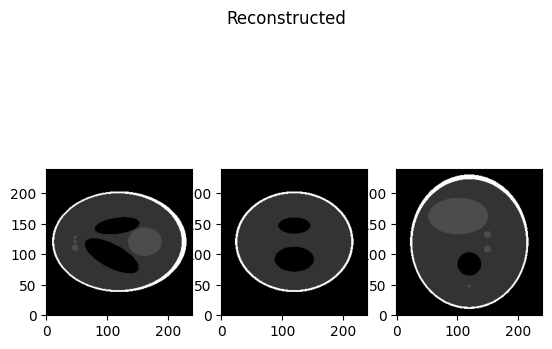

In [2]:
pick_best_angles = False

slice_acq_tester = TestSliceAcq(phantom="sigpy", verbose=True)
if pick_best_angles:
    sorted_indices = slice_acq_tester.test_svort_recon(pick_best_angles=False)
    for idx in sorted_indices:
        fig = show_slices(slice_acq_tester.reconstructed[idx].squeeze(), title=f"Reconstructed {idx}")
else:
    reconstructed = slice_acq_tester.test_svort_recon(pick_best_angles=False)
    fig = show_slices(reconstructed.squeeze(), title=f"Reconstructed")

## Test reconstructing ADNI volume using SVORT

Creating a Phantom of (240, 240, 240) with resolution 1
Testing angles: [[1.57079633, 0.0, 0.0], [0.0, 1.57079633, 0.0], [0.0, 0.0, 1.57079633]]
Mismatches: 2884445/13824000 (21.0%),                     
max error: 0.0023610591888427734
mean error: 3.313089837320149e-05
----------------------------------------------------------


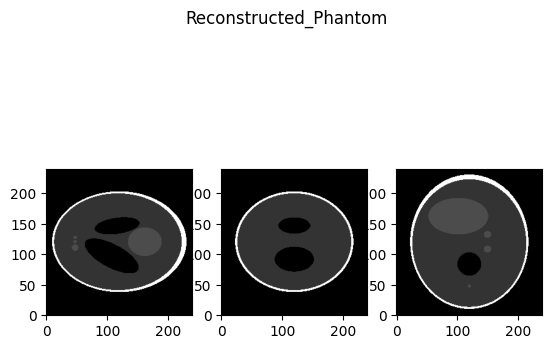

In [3]:
test_ADNI = False

import nibabel as nib
volume = nib.load("ADNI/adcp_alldata_location2/ADCP_harmonization/ADCP_2085/recontruct_ADCP_2085_volume_h.nii.gz").get_fdata()
angles = [
    [1.57079633, 0., 0.],
    [0., 1.57079633, 0.],
    [0., 0., 1.57079633]
    ]

if test_ADNI:
    volume_ = slice_acq_tester.test_svort_recon(volume=volume, angles=angles)
else:
    volume_ = slice_acq_tester.test_svort_recon(angles=angles)
fig = show_slices(volume_.squeeze(), title="Reconstructed" + ("_ADNI" if test_ADNI else "_Phantom"))

## Test FeTA

Using provided volume


Testing angles: [[1.57079633, 0.0, 0.0], [0.0, 1.57079633, 0.0], [0.0, 0.0, 1.57079633]]
Mismatches: 3747286/13824000 (27.0%),                     
max error: 4.5836181640625
mean error: 0.028565187007188797
----------------------------------------------------------


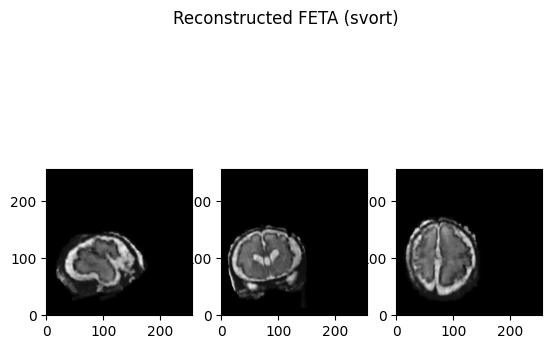

In [4]:
volume = nib.load("feta/sub-001/anat/sub-001_rec-mial_T2w.nii.gz").get_fdata()
volume_ = slice_acq_tester.test_svort_recon(volume=volume, angles=angles)
fig = show_slices(volume_.squeeze(), title="Reconstructed FETA (svort)")
nib.save(nib.Nifti1Image(volume_.squeeze().cpu().numpy(), affine=None), "volumes/feta_rec_svort_gap=3")

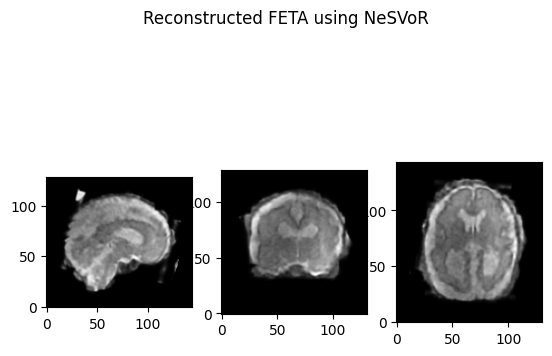

In [9]:
volume = nib.load("volumes/feta_sub-002_rec_volume.nii.gz").get_fdata()
fig = show_slices(volume.squeeze(), title="Reconstructed FETA using NeSVoR")

## Compare the phantom used in the repo the and one I found

Visualizing phantom.nii.gz
Visualizing sigpy_phantom.nii.gz


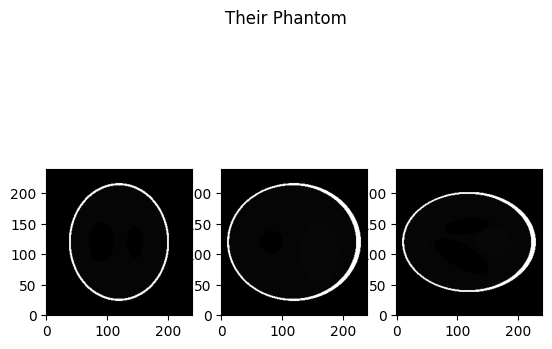

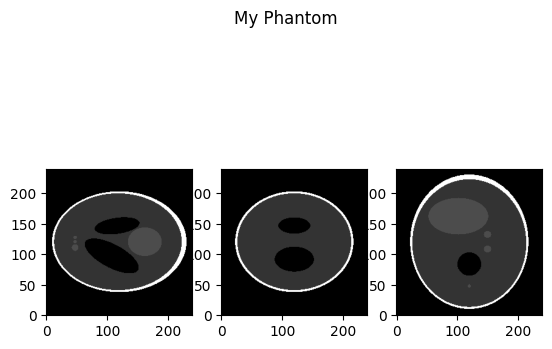

In [8]:
import os

volumes_to_vis = ["phantom.nii.gz", "sigpy_phantom.nii.gz"]
titles = ["Their Phantom", "My Phantom"]
for vol in volumes_to_vis:
    if os.path.exists(vol):
        print(f"Visualizing {vol}")
        volume = nib.load(vol).get_fdata()
        fig = show_slices(volume, title=titles.pop(0))
        # fig.show()